<a href="https://colab.research.google.com/github/aryamanpandya99/AIFundamentals/blob/master/MLPy/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

By Definition, an autoencoder is a neural network trained to downsize then reconstruct its input data from a latent representation. A convolutional autoencoder uses a CNN encoder to compress the input into the a latent representation and a deconvolutional (transposed convolution) decoder to reconstruct the input from the latent representation.

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib.pyplot as plt, numpy as np

In [95]:
import pandas as pd
import pathlib as Path
from torch.utils.data import DataLoader, default_collate, Dataset
from typing import Mapping

In [96]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [97]:
all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'/content/drive/MyDrive/data/cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)

In [98]:
data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)

print("Validation data shape:", x_valid.shape)
print("Validation labels shape:", y_valid.shape)

Training data shape: torch.Size([40000, 3, 32, 32])
Training labels shape: torch.Size([40000])
Validation data shape: torch.Size([10000, 3, 32, 32])
Validation labels shape: torch.Size([10000])


In [99]:
# sample cnn
from torch import nn

simple_cnn = nn.Sequential(
    nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),    # 14x14x4
    nn.ReLU(),
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),    # 7x7x8
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),    # 4x4x16
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),    # 2x2x16
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),    # 1x1x10
    nn.Flatten(),
).to(device)

simple_cnn(x_train[0].unsqueeze(0))

tensor([[-0.0570,  0.0009, -0.0197,  0.0812,  0.0302, -0.0461, -0.0639,  0.0479,
          0.0450, -0.0432]], device='cuda:0', grad_fn=<ViewBackward0>)

In [100]:
def show_torch_image(img):
    img = img.permute(1, 2, 0)
    img = img.numpy().astype(np.uint8)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

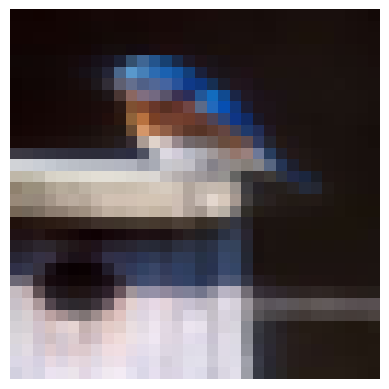

In [101]:
show_torch_image(255 * x_train[13].cpu())

In [102]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

In [103]:
def validate(model, loss_func, valid_dl):
    model.eval()
    with torch.no_grad():
        tot_loss = 0.
        count = 0
        for xb, _ in valid_dl:
            pred = model(xb)
            loss = loss_func(pred, xb)
            tot_loss += loss.item()
            count += len(xb)
    return tot_loss / count

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, xb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        tot_loss_count = validate(model, loss_func, valid_dl)
        print(f"Validation loss: {tot_loss_count}")

In [104]:
class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [105]:
train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

In [106]:
print(len(train_ds))

40000


In [107]:
print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [108]:
model = ConvolutionalAutoencoder()
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [109]:
model.to(device)

ConvolutionalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(4, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [110]:
fit(20, model, loss_func, opt, train_dl, valid_dl)

Epoch 1/20
Validation loss: 0.0004467273283749819
Epoch 2/20
Validation loss: 0.0003937351613305509
Epoch 3/20
Validation loss: 0.0003439155267551541
Epoch 4/20
Validation loss: 0.00032106330380775035
Epoch 5/20
Validation loss: 0.000303196092043072
Epoch 6/20
Validation loss: 0.00029852693458087744
Epoch 7/20
Validation loss: 0.0002880178031977266
Epoch 8/20
Validation loss: 0.0002833798761013895
Epoch 9/20
Validation loss: 0.00028100945209153
Epoch 10/20
Validation loss: 0.0002790189091581851
Epoch 11/20
Validation loss: 0.00027578450143337247
Epoch 12/20
Validation loss: 0.0002745346564333886
Epoch 13/20
Validation loss: 0.0002746266720816493
Epoch 14/20
Validation loss: 0.0002591891399584711
Epoch 15/20
Validation loss: 0.00017180192386731505
Epoch 16/20
Validation loss: 0.0001658275178167969
Epoch 17/20
Validation loss: 0.00016280891536734997
Epoch 18/20
Validation loss: 0.00016054072661790997
Epoch 19/20
Validation loss: 0.00015890196759719402
Epoch 20/20
Validation loss: 0.00015

torch.Size([1, 3, 32, 32])


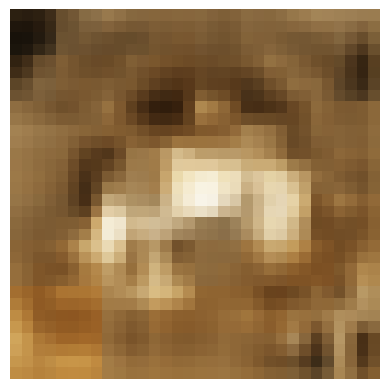

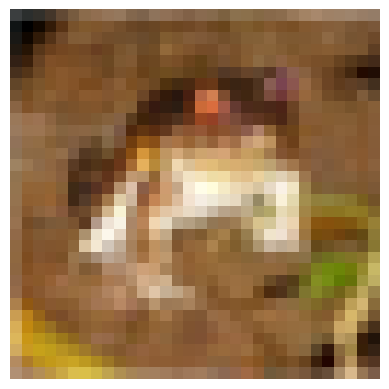

In [111]:
sample_output = model(x_train[0].unsqueeze(0))
print(sample_output.shape)
show_torch_image(255*sample_output.squeeze(0).detach().cpu())
show_torch_image(255 * x_train[0].cpu())

In [112]:
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
fit(20, model, loss_func, opt, train_dl, valid_dl)

Epoch 1/20
Validation loss: 0.00015597435561940073
Epoch 2/20
Validation loss: 0.00015551172692794354
Epoch 3/20
Validation loss: 0.00015508973319083453
Epoch 4/20
Validation loss: 0.00015474253031425177
Epoch 5/20
Validation loss: 0.00015434126073960214
Epoch 6/20
Validation loss: 0.00015402114926837385
Epoch 7/20
Validation loss: 0.00015373483863659202
Epoch 8/20
Validation loss: 0.00015350672148633747
Epoch 9/20
Validation loss: 0.00015335871065035462
Epoch 10/20
Validation loss: 0.00015305071761831642
Epoch 11/20
Validation loss: 0.00015278870535548775
Epoch 12/20
Validation loss: 0.00015260835096705705
Epoch 13/20
Validation loss: 0.00015266072750091554
Epoch 14/20
Validation loss: 0.0001523189471103251
Epoch 15/20
Validation loss: 0.00015227980152703822
Epoch 16/20
Validation loss: 0.0001520885195583105
Epoch 17/20
Validation loss: 0.00015205422437284142
Epoch 18/20
Validation loss: 0.00015185926782432943
Epoch 19/20
Validation loss: 0.0001519000130239874
Epoch 20/20
Validation l

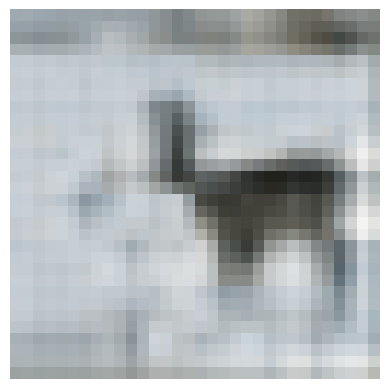

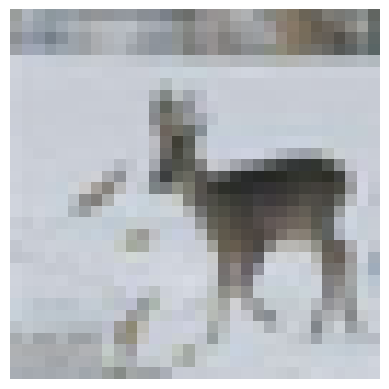

In [118]:
with torch.no_grad():
    sample_output = model(x_train[20].unsqueeze(0))
    show_torch_image(255*sample_output.squeeze(0).detach().cpu())
    show_torch_image(255 * x_train[20].cpu())

## Observations

1. The more we compress with the encoder, the harder it gets to decode with the decoder. This makes sense intuitively, but still needed to be observed practically.

2. A learning rate decay helped marginally, but not substantially. In the above implementation, we might want to try out different tricks to improve model performance (like batch norm, dropout)

3. At first, we only trained our model with 10000 images. For 32x32x3 sized images, this is relatively low. Including images from other batches showed an improvement in the fidelity of the output, and a reduction in the loss. This too, however, seems marginal.

4. Additional non-compressive layers don't seem to help given the current dataset size constraints.
